In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import display
from scipy.stats import pearsonr
import seaborn as sns
from scipy.optimize import nnls  # for non-negative least squares
from scipy.stats import linregress
import matplotlib.patches as mpatches


rc('mathtext', default='regular')

from fun_LR_hydro_memory import *

# === Paths ===
root = '/Users/cag/Dropbox/0_Research/A_Fondecyts/2024_CAG_Ini_11240924/fdcyt_cag_GW_analysis/Analysis_cag_mid'
path_gwl_join_camels = root + '/data/gwl_dga_inner_join_with_CAMELScl_basins.csv' 
path_gwl_join_bna = root + '/data/gwl_dga_inner_join_with_BNA_basins.csv' 

out_figs = root + '/1_LR_all_wells'
if not os.path.exists(out_figs):
    os.makedirs(out_figs)

    
# === Control for overwriting the prediction CSV on first write ===
predictions_file = f"{out_figs}/gw_predicted_all.csv"
overwrite_predictions = True  # Will be set to False after first write


# === Load data ===
pr_camels = pd.read_csv(root + '/data/cr2met_v2p5R1_pr_mon_CAMELScl_ts_1960_2025.csv', parse_dates=['Index'])
pr_bna = pd.read_csv(root + '/data/cr2met_v2p5R1_pr_mon_BNA_ts_1960_2025.csv', parse_dates=['Index'])
et_camels = pd.read_csv(root + '/data/et_wb_mm_mon_cr2met_v2.5_cr2luc_beta_camels_v2025_ts.csv', parse_dates=['date'])
et_bna = pd.read_csv(root + '/data/et_wb_mm_mon_cr2met_v2.5_cr2luc_beta_bna_ts.csv', parse_dates=['date'])

# gw_all = pd.read_csv(root + '/data/cr2sub_mon.csv', parse_dates=['date'])
gw_all = pd.read_csv(root + '/data/cr2sub_mon_filtered.csv', parse_dates=['date'])
clean_codes = [col for col in gw_all.columns if col != 'date']

# # === Clean well codes ===
# well_codes = [col for col in gw_all.columns if col != 'date']
# clean_codes = [x.split('-')[0] for x in well_codes]
# gw_all.rename(columns=dict(zip(well_codes, clean_codes)), inplace=True)

# === Global parameters ===
train_start = "1960-01-01"
train_end   = "2025-12-31"
min_obs = 100

# ========================== RUN THROUGH WELLS ============================

# Dataframes for storing LR results & gwl, precip and et for all wells (one column per well)

r2_summary_all = pd.DataFrame(columns=["well_id", 
                                       "target", 
                                       "predictor", 
                                       "lag_increase", 
                                       "r2", 
                                       "has_neg_coef"])

wells_pr_all = pd.DataFrame()
wells_et_all = pd.DataFrame()
wells_gw_all = pd.DataFrame()

# === Loop through wells with ≥ min obs ===
# for cod in ['03450005','05731003', '05410014']:
# for cod in ['03450005']:
for cod in clean_codes:
    gw = pd.Series(gw_all[cod].values, index=gw_all['date'])
    if gw.notna().sum() < min_obs:
        continue  # Skip well
        
    # Load matching precip
    gauge_id, predictor_source = get_gauge_id(cod, path_gwl_join_camels, path_gwl_join_bna)

    if predictor_source == "camels":
        
        pr = pd.Series(pr_camels[gauge_id].values, index=pr_camels['Index'])
        et = pd.Series(et_camels[gauge_id].values, index=et_camels['date'])
        start, end = max(gw.index.min(), pr.index.min()), min(gw.index.max(), pr.index.max())

        # Build per-well series (index normalized to month-start)
        pr_ser = pd.Series(pr_camels[gauge_id].values, index=pr_camels['Index'], name=cod)
        et_ser = pd.Series(et_camels[gauge_id].values, index=et_camels['date'],  name=cod)
        gw_ser = pd.Series(gw.values,index=gw.index,name=cod)

        # Truncate to common span
        pr_ser = pr_ser.sort_index().loc[start:end]
        et_ser = et_ser.sort_index().loc[start:end]
        gw_ser = gw_ser.sort_index().loc[start:end]

        # Append as new columns (outer-join on dates)
        wells_pr_all = wells_pr_all.join(pr_ser, how='outer') if not wells_pr_all.empty else pr_ser.to_frame()
        wells_et_all = wells_et_all.join(et_ser, how='outer') if not wells_et_all.empty else et_ser.to_frame()
        wells_gw_all = wells_gw_all.join(gw_ser, how='outer') if not wells_gw_all.empty else gw_ser.to_frame()

    elif predictor_source == "bna":
        pr = pd.Series(pr_bna[gauge_id].values, index=pr_bna['Index'])
        et = pd.Series(et_bna[gauge_id].values, index=et_bna['date'])
        start, end = max(gw.index.min(), pr.index.min()), min(gw.index.max(), pr.index.max())

        # Build per-well series (index normalized to month-start)
        pr_ser = pd.Series(pr_bna[gauge_id].values, index=pr_bna['Index'], name=cod)
        et_ser = pd.Series(et_bna[gauge_id].values, index=et_bna['date'],  name=cod)
        gw_ser = pd.Series(gw.values,index=gw.index,name=cod)

        # Truncate to common span
        pr_ser = pr_ser.sort_index().loc[start:end]
        et_ser = et_ser.sort_index().loc[start:end]
        gw_ser = gw_ser.sort_index().loc[start:end]

        # Append as new columns (outer-join on dates)
        wells_pr_all = wells_pr_all.join(pr_ser, how='outer') if not wells_pr_all.empty else pr_ser.to_frame()
        wells_et_all = wells_et_all.join(et_ser, how='outer') if not wells_et_all.empty else et_ser.to_frame()
        wells_gw_all = wells_gw_all.join(gw_ser, how='outer') if not wells_gw_all.empty else gw_ser.to_frame()
        
    else:
        print(f"⚠️ Precip data not available for {cod}. Skipping.")
    

    # Align time
    gw, pr , et = gw[start:end], pr[start:end], et[start:end]
    wa1 = pr - et

    
    if gw.notna().sum() < min_obs:
        continue  # Skip well

        
    # === Compute monthly anomalies (deseasonalize) ===

    gw_an = gw - gw.groupby(gw.index.month).transform('mean')
    pr_an = pr - pr.groupby(pr.index.month).transform('mean')
    et_an = et - et.groupby(et.index.month).transform('mean')
    wa_an1 = wa1 - wa1.groupby(wa1.index.month).transform('mean')

    
    # === De-trend ===

    # GW Detrend
    x_gw = np.arange(len(gw_an))
    y_gw = gw_an.values
    mask_gw = ~np.isnan(y_gw)
    
    # GW Linear trend
    gw_coeffs_lin = np.polyfit(x_gw[mask_gw], y_gw[mask_gw], deg=1)
    gw_trend_lin = np.polyval(gw_coeffs_lin, x_gw)
    gw_an_dt = y_gw - gw_trend_lin
    # GW Linear trend only if significant
    slope, intercept, r_value, p_value, std_err = linregress(x_gw[mask_gw], y_gw[mask_gw])
    if (slope < 0) and (p_value < 0.05):
        gw_an_dt_sig = y_gw - (slope * x_gw + intercept)
    else:
        gw_an_dt_sig = y_gw  # just the anomaly, not detrended

    # Pr Detrend
    x_pr = np.arange(len(pr_an))
    y_pr = pr_an.values
    mask_pr = ~np.isnan(y_pr)
    pr_coeffs_lin = np.polyfit(x_pr[mask_pr], y_pr[mask_pr], deg=1)
    pr_trend_lin = np.polyval(pr_coeffs_lin, x_pr)
    pr_an_dt = y_pr - pr_trend_lin

    # ET Detrend
    x_et = np.arange(len(et_an))
    y_et = et_an.values
    mask_et = ~np.isnan(y_et)
    et_coeffs_lin = np.polyfit(x_et[mask_et], y_et[mask_et], deg=1)
    et_trend_lin = np.polyval(et_coeffs_lin, x_et)
    et_an_dt = y_et - et_trend_lin  

    # wa detrend
    x_wa = np.arange(len(wa_an1))
    y_wa = wa_an1.values
    mask_wa = ~np.isnan(y_wa)
    wa_coeffs_lin = np.polyfit(x_wa[mask_wa], y_wa[mask_wa], deg=1)
    wa_trend_lin = np.polyval(wa_coeffs_lin, x_wa)
    wa_an_dt1 = y_wa - wa_trend_lin
   
    
    
    ### Create predictors for LR (moving window mean precip)
    pr_an_dt = pd.Series(pr_an_dt, index=pr.index, name='an_dt')
    pr_an = pd.Series(pr_an, index=pr.index, name='an')    
    et_an_dt = pd.Series(et_an_dt, index=et.index, name='an_dt')
    et_an = pd.Series(et_an, index=et.index, name='an')  
    wa_an_dt1 = pd.Series(wa_an_dt1, index=wa1.index, name='an_dt')
    wa_an1 = pd.Series(wa_an1, index=wa1.index, name='an')  

    for lag_increase in range(1, 5):
        lag_ranges = make_lag_ranges(lag_increase=lag_increase, n_windows=10)

        # precip
        pred_pr_raw  = rolling_predictors(pr, lag_ranges, standardize=True)
        pred_pr_an_dt  = rolling_predictors(pr_an_dt, lag_ranges, standardize=True)
        pred_pr_an     = rolling_predictors(pr_an,    lag_ranges, standardize=True)

        # ET too
        pred_et_an_dt = rolling_predictors(et_an_dt, lag_ranges, standardize=True)
        pred_et_an    = rolling_predictors(et_an,    lag_ranges, standardize=True)
 
        # water availability
        pred_wa_an_dt1 = rolling_predictors(wa_an_dt1, lag_ranges, standardize=True)
        pred_wa_an1    = rolling_predictors(wa_an1,    lag_ranges, standardize=True)

        # water availability alt 2
        temp_wa_an_dt2 = (rolling_predictors(pr_an_dt, lag_ranges, standardize=False)-
        rolling_predictors(et_an_dt, lag_ranges, standardize=False))

        temp_wa_an2 = (rolling_predictors(pr_an, lag_ranges, standardize=False)-
        rolling_predictors(et_an, lag_ranges, standardize=False))

        pred_wa_an_dt2 = (temp_wa_an_dt2 - temp_wa_an_dt2.mean()) / temp_wa_an_dt2.std()
        pred_wa_an2    = (temp_wa_an2 - temp_wa_an2.mean()) / temp_wa_an2.std()



        # --- Targets ---
        targets = {
            'gw_raw': pd.Series(gw, name='gw_raw', index=gw.index),
            'gw_an': pd.Series(gw_an, name='gw_an', index=gw_an.index),
            'gw_an_dt': pd.Series(gw_an_dt, name='gw_an_dt', index=gw_an.index)
            # 'gw_an_dt_sig': pd.Series(gw_an_dt_sig, name='gw_an_dt_sig',index=gw_an.index)
        }

        # --- Predictor/target combinations ---
        combinations = [
            ('gw_raw', 'pr_raw', pred_pr_raw, 'GW raw = f (precip_raw)'),
            ('gw_an', 'pr_an', pred_pr_an, 'GW anom = f (precip_an)'),
            ('gw_an_dt', 'pr_an_dt', pred_pr_an_dt, 'GW anom dt = f (precip_an_dt)'),
            ('gw_an', 'wa1_an', pred_wa_an1, 'GW anom = f (wa1_an)'),
            ('gw_an_dt', 'wa1_an_dt', pred_wa_an_dt1, 'GW anom dt = f (wa1_an_dt)'),
            ('gw_an', 'wa2_an', pred_wa_an2, 'GW anom = f (wa2_an)'),
            ('gw_an_dt', 'wa2_an_dt', pred_wa_an_dt2, 'GW anom dt = f (wa2_an_dt)')
        ]

       
        coeffs_df = pd.DataFrame(index=pred_pr_an.columns)

        ############# IMPORTANT TO SET TUP #########
        # Set to True to restrict to non-negative coefficients
        restrict_positive = False

        for i, (target_name, pred_name, pred_df, label) in enumerate(combinations):
                        
            y = targets[target_name]
            # Training period
            y_train_period = y.loc[train_start:train_end]
            X_train_period = pred_df.loc[train_start:train_end]
            df_train = pd.concat([y_train_period, X_train_period], axis=1).dropna()
            
            X_train = df_train.drop(columns=target_name).values
            y_train = df_train[target_name].values
            # Fit model
            if restrict_positive:
                coef, _ = nnls(X_train, y_train)
            else:
                coef, _, _, _ = np.linalg.lstsq(X_train, y_train, rcond=None)
            # Save coefficients
            coeffs_df[label] = pd.Series(coef, index=pred_df.columns)

            # Predict for full period
            y_pred_full = pd.Series(index=y.index, dtype=float)
            X_pred = pred_df.loc[y.index].dropna()
            y_pred = X_pred.values @ coef
            y_pred_full.loc[X_pred.index] = y_pred

            if lag_increase == 4:
                pred_out = pd.DataFrame({
                    "date": y.index,
                    "well_id": cod,
                    "target": target_name,
                    "predictor": pred_name,
                    "lag_increase": lag_increase,
                    "raw_obs": gw,
                    "target_val": y.values,
                    "pred": y_pred_full.values
                })

                pred_out.to_csv(
                    predictions_file,
                    mode='w' if overwrite_predictions else 'a',
                    header=overwrite_predictions,
                    index=False
                )
                overwrite_predictions = False  # After first write, switch to append mode

            # R² (full)
            mask_all = y.notna() & y_pred_full.notna()            
            if np.std(y_pred_full[mask_all]) == 0 or np.std(y[mask_all]) == 0:
                r2_all = np.nan
            else:
                corr_all = np.corrcoef(y[mask_all], y_pred_full[mask_all])[0, 1]
                r2_all = corr_all**2 if not np.isnan(corr_all) else np.nan
    
            # R² (train)
            mask_train = y_train_period.notna() & y_pred_full.notna()
            if np.std(y_pred_full[mask_train]) == 0 or np.std(y[mask_train]) == 0:
                r2_train = np.nan
            else:
                corr_train = np.corrcoef(y_train_period[mask_train], y_pred_full[mask_train])[0, 1]
                r2_train = corr_train**2 if not np.isnan(corr_train) else np.nan

            # Store R2 results
            has_neg = (coef < 0).any()

            r2_summary_all = pd.concat([
            r2_summary_all,
            pd.DataFrame([{
                "well_id": cod,
                "target": target_name,
                "predictor": pred_name,
                "lag_increase": lag_increase,
                "r2": r2_all,
                "has_neg_coef": has_neg
            }])
            ], ignore_index=True)

# Add column to identify whether this run used positive coefficient restriction
r2_summary_all['LR_restrict_positive'] = restrict_positive  # or False, depending on the run
r2_summary_all.to_csv(f"{out_figs}/r2_summary_all_restrict_{r2_summary_all['LR_restrict_positive'].iloc[0]}.csv", index=False) 

    
# Save only if we collected any CAMELS/BNA wells
if 'wells_gw_all' in locals() and not wells_gw_all.empty:
    out_dir = os.path.join(out_figs, "gw_p_et_series_combined")
    os.makedirs(out_dir, exist_ok=True)
    out_dir2 = os.path.join(root, "data/gw_wo_p_et_series_combined")
    os.makedirs(out_dir2, exist_ok=True)

    to_save = [
        ("wells_gw_wo_outliers.csv", wells_gw_all),
        ("wells_pr.csv",             wells_pr_all),
        ("wells_et.csv",             wells_et_all),
    ]

    for fname, df in to_save:
        if df is None or df.empty:
            continue
        df = df.sort_index()
        df.index.name = "date"  # keep a clean 'date' index name
        df.to_csv(os.path.join(out_dir, fname))
        df.to_csv(os.path.join(out_dir2, fname))
        
else:
    print("No CAMELS/BNA wells collected — nothing to save.")
    
print("\nLR models Finished! \nFinito! \nTerminado!\n")


LR models Finished! 
Finito! 
Terminado!



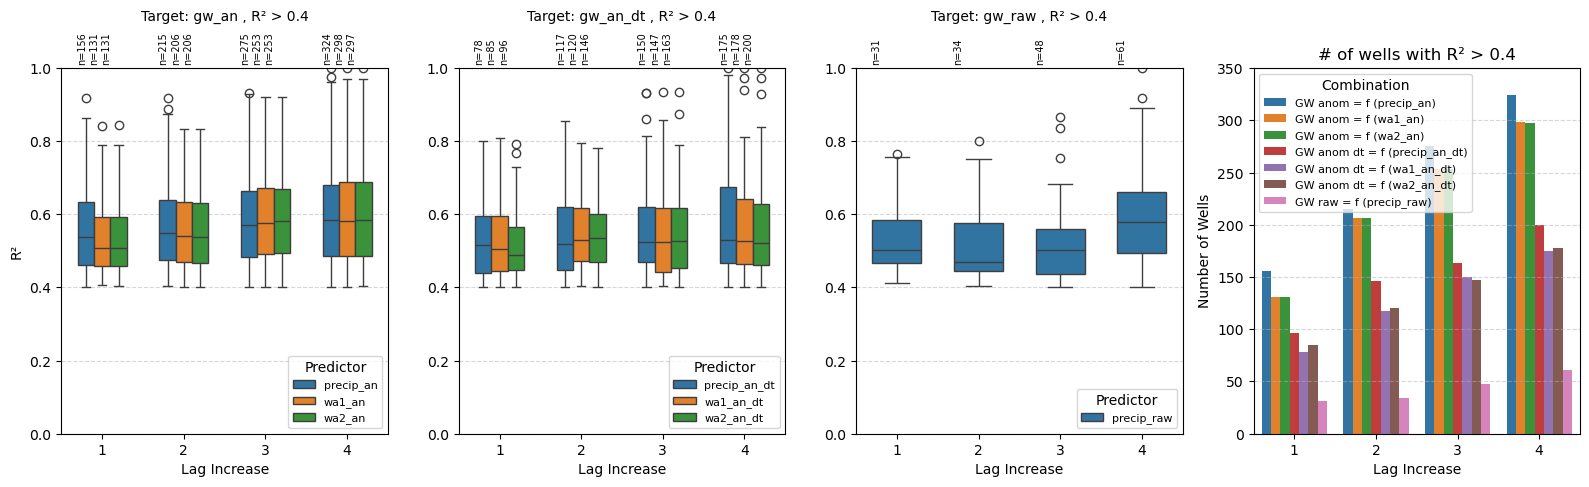

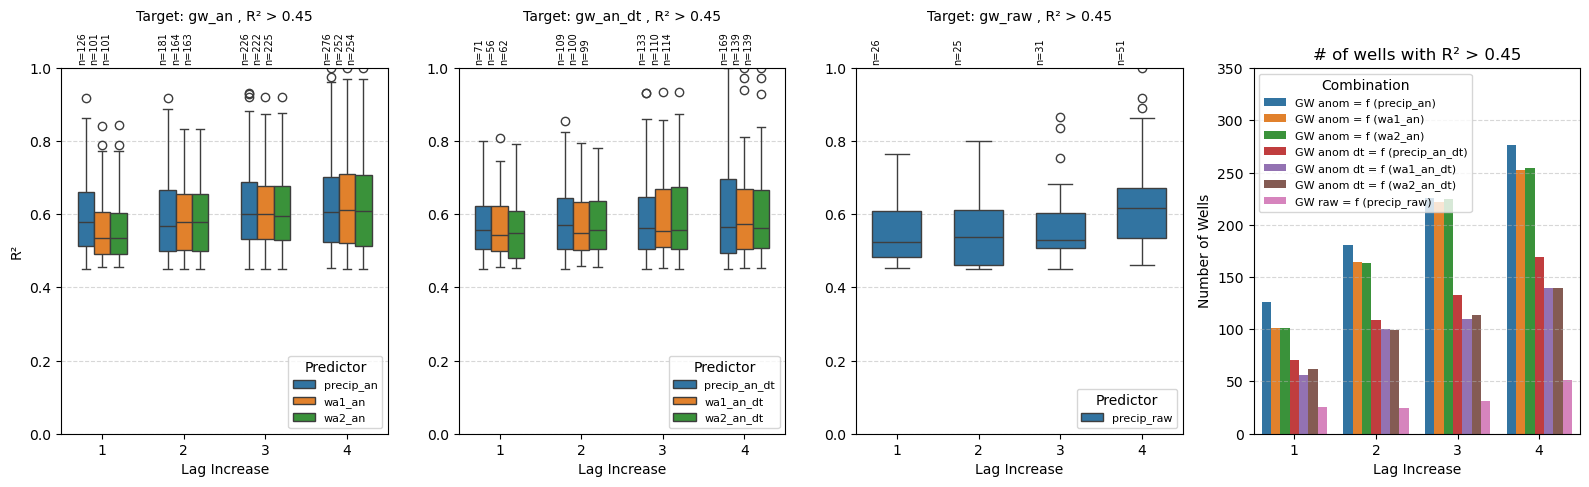

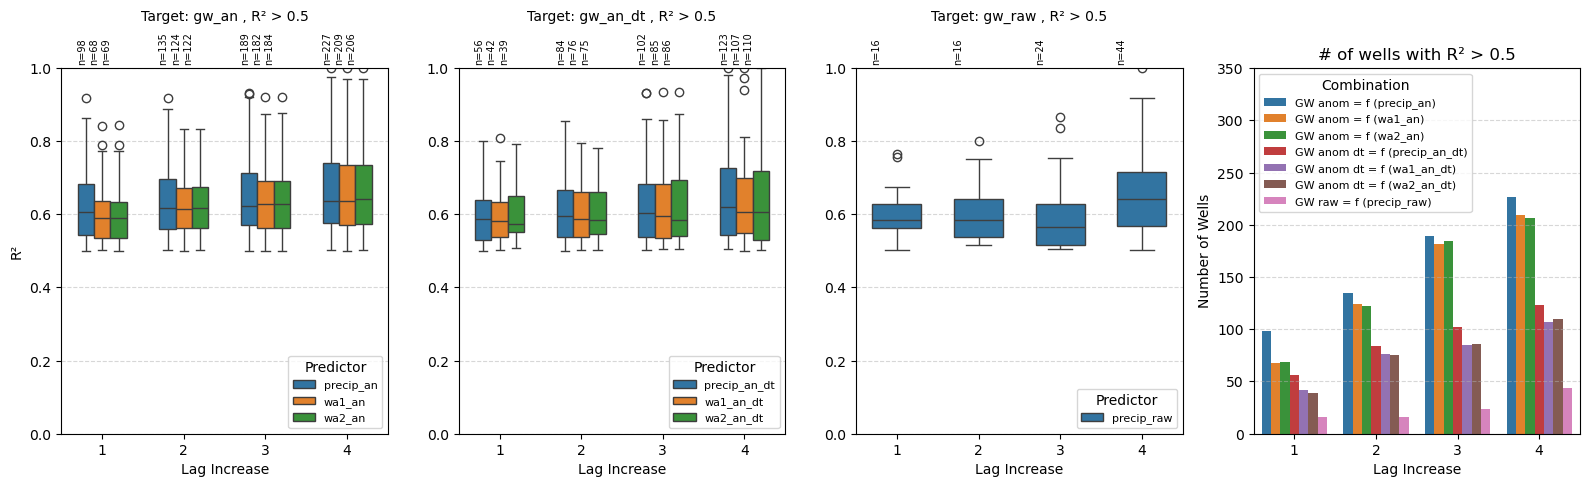

In [2]:
### FUNCTION TO PLOT ALL R2 ###

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_r2_by_target(df, combinations, thr_r2=0.0, title_suffix="", filename="r2_merged_targets"):
    """
    Creates a single figure with:
    - Two boxplots (one per target) showing R² per lag, grouped by predictor.
    - One bar plot showing the number of wells (y) with R² > threshold per lag (x), per combination.
    """
    # === Prep combinations info ===
    used_combos = [(t, p) for (t, p, _, _) in combinations]
    label_map = {(t, p): label for (t, p, _, label) in combinations}
    pred_label_map = {(t, p): label.split('= f (')[-1].rstrip(')') for (t, p, _, label) in combinations}
    targets = sorted(set(t for t, _, _, _ in combinations))

    # === Filter R² data ===
    df = df[df[['target', 'predictor']].apply(tuple, axis=1).isin(used_combos)].copy()
    df = df[df['r2'] > thr_r2]
    df['combo_label'] = df.apply(lambda row: label_map.get((row['target'], row['predictor'])), axis=1)
    df['predictor_label'] = df.apply(lambda row: pred_label_map.get((row['target'], row['predictor'])), axis=1)

    # === Count summary ===
    count_df = (
        df.groupby(['target', 'predictor', 'lag_increase'])['well_id']
        .nunique()
        .reset_index(name='n_wells')
    )
    count_df['combo_label'] = count_df.apply(lambda row: label_map.get((row['target'], row['predictor'])), axis=1)

    # === Setup 3-panel figure ===
    fig, axs = plt.subplots(1, 4, figsize=(16, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1]}, sharey=False)

    for i, t in enumerate(targets):
        ax = axs[i]
        df_plot = df[df['target'] == t]
        if df_plot.empty:
            ax.text(0.5, 0.5, "No data", ha='center', va='center')
            ax.set_axis_off()
            continue

        sns.boxplot(data=df_plot, x='lag_increase', y='r2', hue='predictor_label', ax=ax, width=0.6)

        # Annotate number of wells per box
        grouped = df_plot.groupby(['lag_increase', 'predictor_label'])['well_id'].nunique().reset_index(name='count')
        for j, pred in enumerate(df_plot['predictor_label'].unique()):
            for lag in sorted(df_plot['lag_increase'].unique()):
                subset = grouped[(grouped['lag_increase'] == lag) & (grouped['predictor_label'] == pred)]
                if not subset.empty:
                    count = subset['count'].values[0]
                    xpos = lag - 1 + j * 0.15 - 0.25
                    ax.text(x=xpos, y=1.01, s=f"n={count}",
                            ha='center', va='bottom', fontsize=7, rotation=90,
                            transform=ax.get_xaxis_transform())

        ax.set_ylim(0, 1)
        ax.text(0.5, 1.13, f"Target: {t} {title_suffix}", transform=ax.transAxes, ha='center', fontsize=10)
        ax.set_xlabel("Lag Increase")
        ax.set_ylabel("R²" if i == 0 else "")
        ax.grid(axis='y', linestyle='--', alpha=0.5)

        # Inline legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title="Predictor", fontsize=8, loc='lower right')

    # === fourth panel: Barplot of number of wells with R² > threshold ===
    ax = axs[3]
    sns.barplot(
        data=count_df,
        x='lag_increase',
        y='n_wells',
        hue='combo_label',
        ax=ax
    )
    ax.set_ylim(0, 350)
    ax.set_title(f"# of wells with R² > {thr_r2}")
    ax.set_xlabel("Lag Increase")
    ax.set_ylabel("Number of Wells")
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.legend(title="Combination", fontsize=8, loc='upper left')

    plt.tight_layout()
    plt.savefig(f"{out_figs}/{filename}.pdf", bbox_inches='tight')
    plt.show()


# === Load R² CSV ===
# df_r2 = pd.read_csv(f"{out_figs}/r2_summary_all_restrict_False.csv")  # or _False
df_r2 = r2_summary_all
plot_r2_by_target(
    df=df_r2,
    combinations=combinations,
    thr_r2=0.4,
    title_suffix=", R² > 0.4",
    filename="r2_summary_filt04"
)  

plot_r2_by_target(
    df=df_r2,
    combinations=combinations,
    thr_r2=0.45,
    title_suffix=", R² > 0.45",
    filename="r2_summary_filt045"
) 


plot_r2_by_target(
    df=df_r2,
    combinations=combinations,
    thr_r2=0.5,
    title_suffix=", R² > 0.5",
    filename="r2_summary_filt05"
) 

In [3]:
### FUNCTION TO PLOT OBS VS PREDICTED TIMSERIES ###

import pandas as pd
import matplotlib.pyplot as plt
import os

# === Paths ===
predicted_file = root + '/1_LR_all_wells/gw_predicted_all.csv'  # ← UPDATE THIS

# === Load data ===
df = pd.read_csv(predicted_file, parse_dates=['date'], dtype={'well_id': str})

from sklearn.metrics import r2_score

# Output folder
out_dir = root + '/1_LR_all_wells/figs_obs_sim'
os.makedirs(out_dir, exist_ok=True)

combinations = [
    # ('gw_raw', 'pr_raw', None, 'GW raw = f (precip_raw)'),
    ('gw_an', 'pr_an', None, 'GW anom = f (precip_an)'),
    ('gw_an_dt', 'pr_an_dt', None, 'GW anom dt = f (precip_an_dt)'),
    ('gw_an', 'wa1_an', None, 'GW anom = f (wa1_an)'),
    ('gw_an_dt', 'wa1_an_dt', None, 'GW anom dt = f (wa1_an_dt)'),
    ('gw_an', 'wa2_an', None, 'GW anom = f (wa2_an)'),
    ('gw_an_dt', 'wa2_an_dt', None, 'GW anom dt = f (wa2_an_dt)')
]

wells = df['well_id'].unique()
lags = df['lag_increase'].unique()

# for cod in ['03451017']:
for cod in wells:
    for lag in [4]:
        subset = df[(df['well_id'] == cod) & (df['lag_increase'] == lag)]
        if subset.empty:
            continue

        start, end = subset['date'].min(), subset['date'].max()

        fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex=True)
        axs = axs.ravel()

        for i, (target, predictor, _, label) in enumerate(combinations):
            combo_data = subset[(subset['target'] == target) & (subset['predictor'] == predictor)]
            ax = axs[i]

            if not combo_data.empty:
                valid = combo_data[['target_val', 'pred']].dropna()
                r2 = r2_score(valid['target_val'], valid['pred']) if not valid.empty else None
                title = f"{label}, R² = {r2:.2f}" if r2 is not None else f"{label}, R² = NA"

                # Primary axis: anomalies/detrended
                p1 = ax.scatter(combo_data['date'], combo_data['target_val'], color='black', s=6, label='Obs (target)')
                p2, = ax.plot(combo_data['date'], combo_data['pred'], color='red', lw=1, label='Sim (target)')

                # Secondary axis: raw observations
                ax2 = ax.twinx()
                p3 = ax2.scatter(combo_data['date'], combo_data['raw_obs'], color='grey', s=6, alpha=0.5, label='Obs (raw)')
                ax2.tick_params(axis='y', labelcolor='grey')
                ax2.spines['right'].set_color('grey')
                ax2.yaxis.label.set_color('grey')

                ax.set_title(title, fontsize=9)
                ax.grid(True)
                ax.set_xlim(start, end)

                if i == 0:
                    # Only one legend to avoid clutter
                    ax.legend(
                        handles=[p3, p1, p2],
                        labels=["Obs (raw)", "Obs (target)", "Sim (target)"],
                        fontsize=8,
                        loc='upper left',
                        frameon=True
                    )

                if i % 2 == 0:
                    ax.set_ylabel("Anomaly")
                if i >= 4:
                    ax.set_xlabel("Date")
            else:
                ax.text(0.5, 0.5, "No data", ha='center', va='center')
                ax.set_axis_off()

        fig.suptitle(f"Well {cod} – predictors with lag = {lag}", fontsize=12)
        plt.tight_layout()
        # plt.show()
        plt.savefig(os.path.join(out_dir, f"{cod}_lag{lag}.pdf"), bbox_inches='tight')
        plt.close()

print("\nLR Plots Finished! \nFinito! \nTerminado!\n")


LR Plots Finished! 
Finito! 
Terminado!

